In [1]:
import sys
# sys.path.append('/home/ajhnam/plinko_nn/src')
# sys.path.append('/home/plinkoproj/plinko_nn/src')
sys.path.append('../src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.model.predictor_gru import GRUPredictor_mu
from plinko.model.predictor_gru import GRUPredictor_determ
from plinko.misc import plot as plinko_plot

# import matplotlib.pyplot as plt
# from plotnine import *
# %matplotlib inline

Loading chipmunk for Linux (64bit) [/opt/anaconda3/lib/python3.7/site-packages/pymunk/libchipmunk.so]


In [2]:
# device = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

In [3]:
# repo_path = '/home/plinkoproj/plinko_nn'
repo_path = '../'
df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

# df_ball = pd.read_feather(repo_path + '/data/training/sim_ball.feather')
# df_env = pd.read_feather(repo_path + '/data/training/sim_environment.feather')
# df_col = pd.read_feather(repo_path + '/data/training/sim_collisions.feather')

In [4]:
# create df with collision data
collisions = df_col.copy()
collisions = collisions.rename({'object': 'collision'}, axis=1)
collisions.t -= 1
collisions = df_ball.merge(collisions, how='left')
collisions.collision[collisions.collision.isna()] = 'none'
collisions.collision[(collisions.collision == 'walls') & (collisions.px < 100)] = 'left_wall'
collisions.collision[(collisions.collision == 'walls') & (collisions.px > 500)] = 'right_wall'
collisions = collisions.sort_values(['simulation', 'run', 't'])
idx2col = sorted(collisions.collision.unique())
col2idx = {c: i for c, i in zip(idx2col, range(len(idx2col)))}
collisions['col'] = [col2idx[c] for c in collisions.collision]
df_collision = collisions.drop(columns="collision")

# if input collision at next time point
# next_col = collisions.groupby(['simulation', 'run'], as_index=False).apply(lambda x: x.iloc[1:]).reset_index().col
# df_collision = collisions.drop(columns="collision").groupby(['simulation', 'run'], as_index=False).apply(lambda x: x.iloc[:-1]).reset_index()
# df_collision.col = next_col


sim_data = data_utils.get_sim_data(df_collision, df_col)
selected_runs = sim_data[(sim_data.num_collisions == 2)
                         & (sim_data.duration < 80)
                         & (sim_data.run <= 20)]
simulations, environments = data_utils.create_task_df(selected_runs, df_collision, df_env)
states, envs = data_utils.to_tensors(simulations, environments, device, include_v=True, include_t=True)
states[:, :, 2:4] = (states[:, :, 2:4] + 20) # transform velocity to all positive

In [5]:
# print(selected_runs)
# print(df_ball)
# simulations.t.max()
# print(df_col[df_col['simulation'] == 'sim_1'])

# del df_ball, df_env, df_col

# print(states.shape)
# print(envs.shape)
# print(states[0, :, 2])
# print(collisions[:20])
# print(df_collision[:20])
# print(states[0])
print(idx2col)

['ground', 'left_wall', 'none', 'pentagon', 'rectangle', 'right_wall', 'triangle']


In [6]:
# model = GRUPredictor(env_size=11, state_size=2, num_gaussians=2).to(device)
# model = GRUPredictor_mu(env_size=11, state_size=2, num_gaussians=1, trainable_h0 = True).to(device)
model = GRUPredictor_determ(env_size=11, state_size=6, gru_hidden_size=64, num_gaussians=1, trainable_h0 = True).to(device)
# optimizer = optim.SGD(model.parameters(), lr=.001)
optimizer = optim.Adam(model.parameters(), lr = 10e-4, weight_decay=.001)
dataset = SimulationDataset(envs, states)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [36]:
# Train GRU_deterministic
# todo: add time-point information for each state?
# todo: integrate a collision classifier?

# optimizer = optim.Adam(model.parameters(), lr = 10e-4, weight_decay=.001)

max_t = simulations.t.max()
epochs = 1000
losses = []
p_overtime = []
v_overtime = []
target_overtime = []
rows = []
# for epoch in tqdm(range(epochs+1)):
for epoch in tqdm(range(71)):
    epoch_loss = 0
    epoch_p_loss = 0
    epoch_v_loss = 0
    epoch_col_loss = 0
    for batch_i, batch in enumerate(dataloader):
        optimizer.zero_grad()

        #         print('Batch ', batch_i)
        p_batch, v_batch, t_batch, col_outputs = model(batch['envs'], batch['states'], 0)
        targets = batch['targets']

        p_mse_loss = F.mse_loss(p_batch, targets[:, :, :2])
        v_mse_loss = .002 * F.mse_loss(v_batch, targets[:, :, 2:4])
        col_targets = torch.tensor(batch['states'][:, :, 4].reshape(-1), dtype=torch.long, device=device)
        col_loss = F.cross_entropy(col_outputs, col_targets)
        loss = p_mse_loss + v_mse_loss + col_loss
        loss.backward(retain_graph=True)
        optimizer.step()
        epoch_loss += loss
        epoch_p_loss += p_mse_loss
        epoch_v_loss += v_mse_loss
        epoch_col_loss += col_loss
        if batch_i == 0:
            p_overtime.append(p_batch)
            v_overtime.append(v_batch)
            target_overtime.append(targets)

    losses.append((epoch, float(epoch_p_loss), float(epoch_v_loss), float(epoch_col_loss),))
        

    if epoch % 1 == 0:
        print('Epoch {} | p_loss: {} | v_loss: {} | | col_loss: {} | total: {}'.format(epoch,
                                                                      round(float(epoch_p_loss), 4),
                                                                      round(float(epoch_v_loss), 4),
                                                                      round(float(epoch_col_loss), 4),
                                                                      round(float(epoch_loss), 4)))
        corrects = (col_outputs.argmax(-1) == col_targets).float()
        accuracy = float(corrects.mean())
        print("accuracy", round(accuracy, 4))
        row = {'epoch': epoch, 'loss': loss, 'acc_total': accuracy}
        rows.append(row)
        
summary = pd.DataFrame(rows)

#     if (loss - prev_loss) < .1 and (loss - prev_loss) > -.1:
#         break

torch.save(model.state_dict(), 'gru_determ.model')
torch.save(p_overtime, 'p_overtime.pt')
torch.save(v_overtime, 'v_overtime.pt')
torch.save(target_overtime, 'target_overtime.pt')
torch.save(losses, 'losses.pt')

Epoch 0 | p_loss: 4.2931 | v_loss: 4.0875 | | col_loss: 12.0033 | total: 20.3839
accuracy 0.9784
Epoch 1 | p_loss: 4.0804 | v_loss: 3.8758 | | col_loss: 11.453 | total: 19.4091
accuracy 0.9806
Epoch 2 | p_loss: 3.7908 | v_loss: 3.7299 | | col_loss: 11.3876 | total: 18.9083
accuracy 0.9777
Epoch 3 | p_loss: 3.5619 | v_loss: 3.6033 | | col_loss: 11.5736 | total: 18.7388
accuracy 0.9873
Epoch 4 | p_loss: 3.2897 | v_loss: 3.4862 | | col_loss: 10.9526 | total: 17.7285
accuracy 0.9829
Epoch 5 | p_loss: 2.9477 | v_loss: 3.3692 | | col_loss: 11.1325 | total: 17.4493
accuracy 0.9814
Epoch 6 | p_loss: 2.5408 | v_loss: 3.2466 | | col_loss: 10.8104 | total: 16.5978
accuracy 0.9821
Epoch 7 | p_loss: 2.1139 | v_loss: 3.114 | | col_loss: 10.9748 | total: 16.2027
accuracy 0.9851
Epoch 8 | p_loss: 1.7737 | v_loss: 2.9743 | | col_loss: 10.5528 | total: 15.3007
accuracy 0.9851
Epoch 9 | p_loss: 1.9262 | v_loss: 2.8456 | | col_loss: 10.7544 | total: 15.5261
accuracy 0.9821
Epoch 10 | p_loss: 2.0602 | v_lo

    epoch                                               loss  acc_total
0       0  tensor(0.1304, device='cuda:0', grad_fn=<AddBa...   0.978407
1       1  tensor(0.1253, device='cuda:0', grad_fn=<AddBa...   0.980640
2       2  tensor(0.1273, device='cuda:0', grad_fn=<AddBa...   0.977662
3       3  tensor(0.1238, device='cuda:0', grad_fn=<AddBa...   0.987342
4       4  tensor(0.1240, device='cuda:0', grad_fn=<AddBa...   0.982874
..    ...                                                ...        ...
66     66  tensor(0.0790, device='cuda:0', grad_fn=<AddBa...   0.987342
67     67  tensor(0.0777, device='cuda:0', grad_fn=<AddBa...   0.987342
68     68  tensor(0.0788, device='cuda:0', grad_fn=<AddBa...   0.987342
69     69  tensor(0.0794, device='cuda:0', grad_fn=<AddBa...   0.986597
70     70  tensor(0.0785, device='cuda:0', grad_fn=<AddBa...   0.986597

[71 rows x 3 columns]


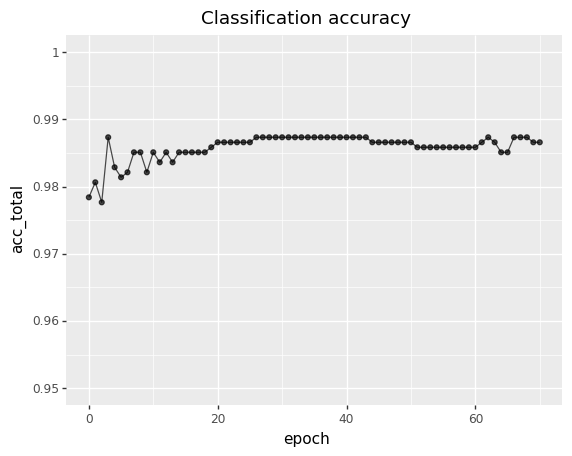

<ggplot: (8769983269281)>


In [42]:
# print(p_batch[0, :10])
# print(targets[0, :10, :])

# print(col_outputs.argmax(-1)[200:400])
# print(col_targets[200:400])
# print(p_overtime[50])
# print(targets[:, :, :2].shape)
print(summary)

p = (ggplot(summary, aes('epoch', 'acc_total'))
        + geom_path(alpha = .7)
        + geom_point(alpha = .7)
         + ylim(.95, 1)
        + labs(title = 'Classification accuracy')
        )
print(p)

In [13]:
p_overtime = torch.load('p_overtime.pt')
v_overtime = torch.load('v_overtime.pt')
target_overtime = torch.load('target_overtime.pt')
losses = torch.load('losses.pt')

# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load('gru_determ.model'))
model.eval()

GRUPredictor_determ(
  (env_embedder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=32, bias=True)
    )
  )
  (state_embedder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=6, out_features=16, bias=True)
    )
  )
  (gru): GRU(48, 64, num_layers=2)
  (mlp): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (col_classifier): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=15, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): Linear(in_features=64, out_features=7, bias=True)
    )
  )
)

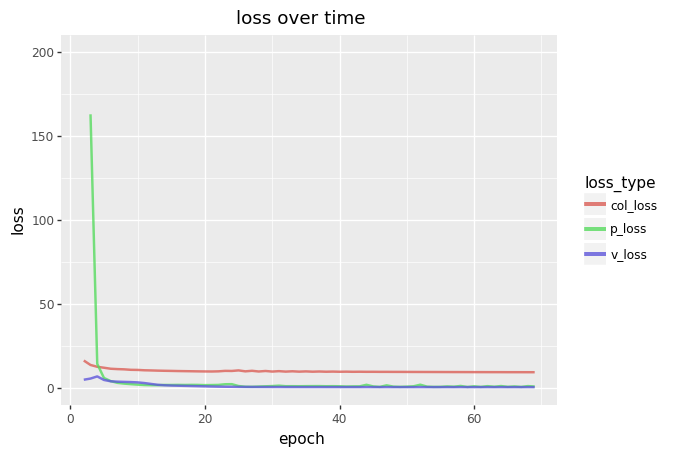

<ggplot: (8769983515189)>


In [27]:
# print(losses)
import matplotlib.pyplot as plt
from plotnine import *

def plot_losses(losses, time_range = None, title = 'loss over time', alpha = .5, shape = '.',filename=None):
    """
    :losses: tuples or array of losses (each row is one timepoint, and the 3 columns are epoch, batch_i, and loss)
    :time_range: the range in timepoint you want to plot
    :title: title of the plot
    :return: plot the loss over time
    """
    df_losses = pd.DataFrame(losses, columns =['epoch', 'p_loss', 'v_loss', 'col_loss'])
    if time_range is None:
        time_range = range(len(df_losses))
    df_losses_long = pd.melt(df_losses, id_vars= ['epoch'], var_name='loss_type', value_name='loss')
    df_losses_long['loss_type'] = df_losses_long['loss_type'].astype('str') 
#     print(df_losses.dtypes)
#     print(df_losses_long.dtypes)

    p = (ggplot(df_losses_long, aes('epoch', 'loss', color = 'loss_type'))
        + geom_path(alpha = alpha, size = 1)
#         + geom_point(alpha = alpha, shape = shape)
        + xlim(time_range[0], time_range[-1])
        + ylim(0, 200)
        + labs(title = title)
        )
    print(p)
    if filename is not None:
        ggsave(filename=filename,
               plot=p,
               device='png')

# df_losses = pd.DataFrame(losses, columns =['epoch', 'p_loss', 'v_loss', 'col_loss'])
# df_losses.apply(pd.to_numeric)
# df_losses_long = pd.melt(df_losses, id_vars= ['epoch'], var_name='loss_type', value_name='loss')
# df_losses_long['type'] = df_losses_long.loss_type.astype(str)
# print(df_losses.dtypes)
# print(df_losses_long.dtypes)


plot_losses(losses, alpha = .8, time_range = range(2, 70))
        
# plinko_plot.plot_losses(losses)

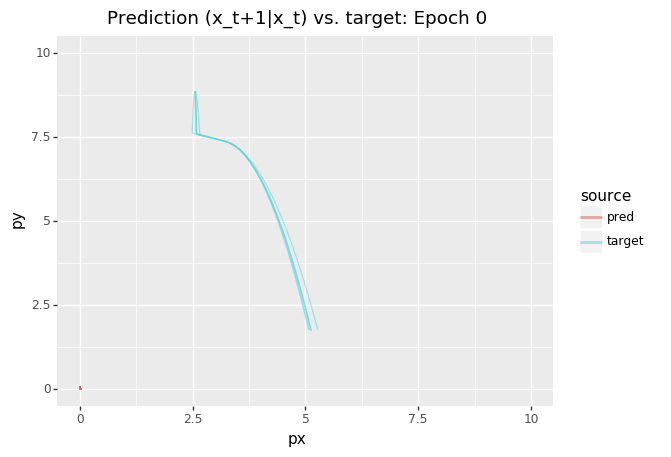

<ggplot: (8769983821997)>


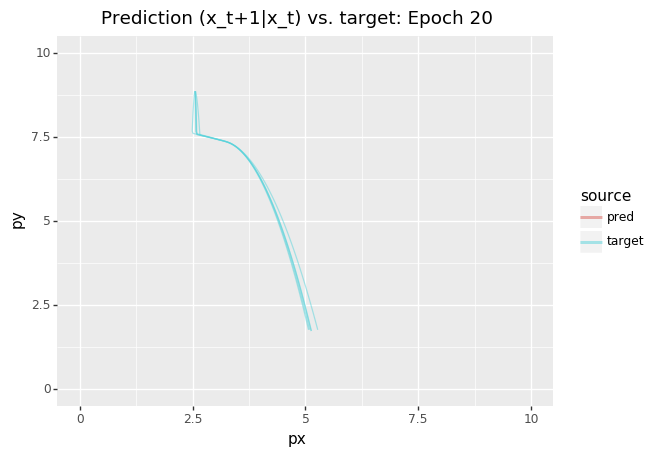

<ggplot: (8769983655669)>


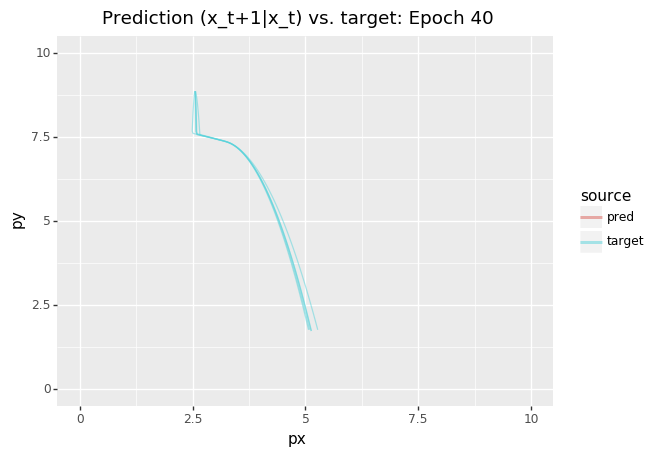

<ggplot: (8769983448121)>


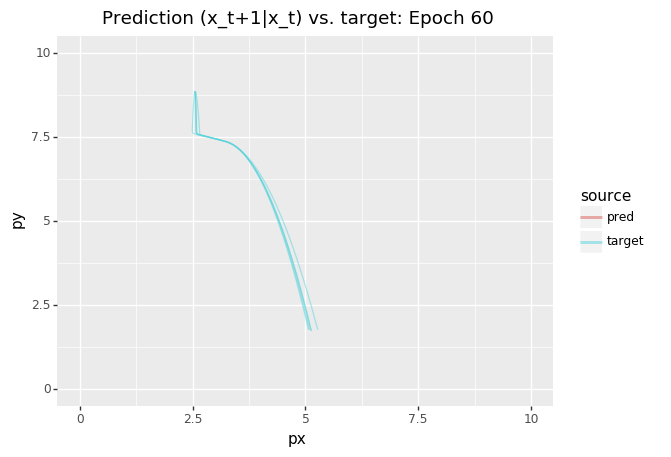

<ggplot: (8769983287901)>


In [28]:
# print(target_overtime[0][:, :, 2:])
# print(p_overtime[0].shape)
# print(v_overtime[0])

for t in range(len(p_overtime)):
    if t %20 == 0:
        plinko_plot.plot_pred_target(p_overtime[t], target_overtime[t][:, :, :2], sim_range = range(10, 15), alpha = .5,
                                    title = "Prediction (x_t+1|x_t) vs. target: Epoch {}".format(t))

In [8]:
def simulate_model(model, dataset, sim_t=1):
    """
    :sim_t = how many time points to feed in for the simulation
    """
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    i = 0
    for batch in dataloader:
        i += 1
        with torch.no_grad():
            p, v = model(batch['envs'], batch['states'][:, 0:sim_t], dataset[0]['states'].shape[0] - sim_t)
            targets = batch['targets'][:, 1:101]
            envs = batch['envs']
            #             df_env, df_ball = data_utils.create_simdata_from_samples(samples, batch['envs'],sim_df, env_df)

            return p, v, targets, envs

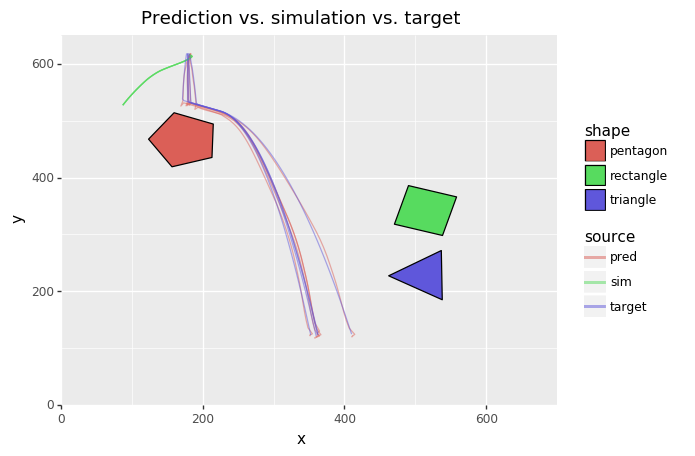

<ggplot: (8753727762481)>


In [15]:
# print(sim_samples.shape)
# print(sim_targets.shape)
# print(gm.mu.shape)

# print(dataset[0]['states'].shape[0])
# simulate from trained model
sim_p, sim_v, sim_targets, sim_envs = simulate_model(model, dataset, sim_t = 1)

# plinko_plot.plot_pred_target(sim_p, sim_targets[:, :, :2], sim_range=range(1),
#                              alpha = .3, title = "Full simulation: prediction vs. target")

plinko_plot.plot_pred_sim_target(p_overtime[len(p_overtime) - 1], sim_p, sim_targets[:, :, :2], sim_envs, 
                                 sim_range=range(5), env_index = 10, alpha = .5)